In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Dict, Tuple
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import stopwords
import re

In [ ]:
class TextPreprocessor:        
    def preprocess_text(self, text: str) -> str:
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        text = re.sub(r'\s+', ' ', text)
        
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        text = text.lower()
        
        text = text.strip()
    
        #stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        
        return text   

In [ ]:
class NaiveBayesBoW:
    def __init__(self, alpha=1.0):
        self.vocabulary = set()
        self.class_priors = {}
        self.word_likelihoods = {}
        self.class_word_counts = {}
        self.smoothing_alpha = alpha
        self.preprocessor = TextPreprocessor()
    
    def _tokenize(self, text: str) -> List[str]:
        processed_text = self.preprocessor.preprocess_text(text)
        return processed_text.split()
    
    def _create_bow(self, tokens: List[str]) -> Dict[str, int]:
        return Counter(tokens)
    
    def train(self, texts: List[str], labels: List[int]):
        total_docs = len(texts)
        label_counts = Counter(labels)
        self.class_priors = {
            label: count/total_docs 
            for label, count in label_counts.items()
        }
        
        self.class_word_counts = {0: Counter(), 1: Counter()}
        
        for text, label in zip(texts, labels):
            tokens = self._tokenize(text)
            self.vocabulary.update(tokens)
            self.class_word_counts[label].update(tokens)
        
        vocab_size = len(self.vocabulary)
        
        self.word_likelihoods = {0: {}, 1: {}}
        for label in [0, 1]:
            total_words = sum(self.class_word_counts[label].values())
            
            for word in self.vocabulary:
                word_count = self.class_word_counts[label].get(word, 0)
                likelihood = (word_count + self.smoothing_alpha) / (total_words + self.smoothing_alpha * vocab_size) #smoothing
                self.word_likelihoods[label][word] = likelihood
                
        return self
    
    def predict(self, text: str) -> Tuple[int, float]:
        tokens = self._tokenize(text)
        bow = self._create_bow(tokens)
        
        #log probabilities
        log_probs = {}
        for label in [0, 1]:
            log_prob = np.log(self.class_priors[label])
            
            for word, count in bow.items():
                if word in self.vocabulary:
                    log_prob += count * np.log(self.word_likelihoods[label].get(word, 1e-10))
            
            log_probs[label] = log_prob
        
        predicted_class = max(log_probs, key=log_probs.get)
        confidence = np.exp(log_probs[predicted_class]) / sum(np.exp(val) for val in log_probs.values())
        
        return predicted_class, confidence
    
    def get_most_informative_words(self, n=20) -> pd.DataFrame:
        word_scores = []
        for word in self.vocabulary:
            score = abs(np.log(self.word_likelihoods[1][word]) - np.log(self.word_likelihoods[0][word]))
            word_scores.append((word, score))
        
        return pd.DataFrame(
            sorted(word_scores, key=lambda x: x[1], reverse=True)[:n],
            columns=['word', 'score']
        )

In [ ]:
def prepare_data(filepath: str) -> pd.DataFrame:
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    
    preprocessor = TextPreprocessor()
    df['processed_text'] = df['text'].apply(preprocessor.preprocess_text)
    
    return df

train_df = prepare_data('train/train_short.jsonl')
test_df = prepare_data('test/test_short.jsonl')

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

display(pd.DataFrame({
    'Original': train_df['text'].head(),
    'Preprocessed': train_df['processed_text'].head()
}))

Training set shape: (8000, 8)
Test set shape: (1000, 13)


,Original,Preprocessed
0,"In Asia, the spread of Buddhism led to large-s...",asia spread buddhism led largescale ongoing tr...
1,Ygapema plaumanni is a species of moth in the ...,ygapema plaumanni species moth family erebidae...
2,"Feleti Vaka'uta Sevele (born July 7, 1944) is ...",feleti vakauta sevele born july tongan politic...
3,"Christian and Joseph Cousins (born March 21, 1...",christian joseph cousins born march american c...
4,Both bread yeast and brewers yeast are general...,bread yeast brewers yeast generally species br...


C:\Users\dhyey\AppData\Local\Temp\ipykernel_4336\3737711799.py:66: RuntimeWarning: invalid value encountered in scalar divide
  confidence = np.exp(log_probs[predicted_class]) / sum(np.exp(val) for val in log_probs.values())


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64       500
           1       0.65      0.78      0.71       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000



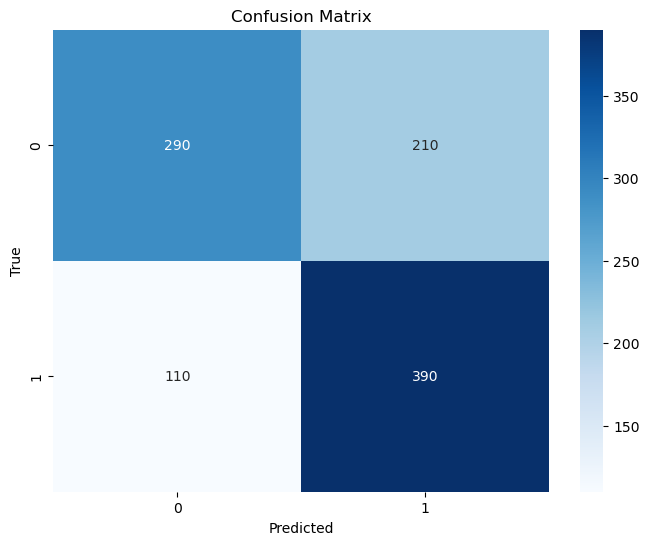

In [ ]:
classifier = NaiveBayesBoW(alpha=1.0)
classifier.train(train_df['processed_text'].tolist(), train_df['label'].tolist())

predictions = []
confidences = []

for text in test_df['processed_text']:
    pred, conf = classifier.predict(text)
    predictions.append(pred)
    confidences.append(conf)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(test_df['label'], predictions))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_df['label'], predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Most informative words:")
display(classifier.get_most_informative_words(n=40))

Most informative words:


,word,score
0,wellstructured,6.044563
1,nt,5.952861
2,commendable,5.933337
3,basically,5.391136
4,davidson,5.386198
5,ive,5.248414
6,interplay,4.734254
7,daunting,4.717860
8,hamster,4.472379
9,cmv,4.381995


In [ ]:
def predict_interactive(text):
    preprocessor = TextPreprocessor()
    processed_text = preprocessor.preprocess_text(text)
    
    print("Original text:", text)
    print("Preprocessed text:", processed_text)
    print("\nPrediction:")
    
    pred_class, confidence = classifier.predict(processed_text)
    print(f"Predicted class: {'machine' if pred_class == 1 else 'human'}")
    print(f"Confidence: {confidence:.4f}")
    
    tokens = processed_text.split()
    word_scores = []
    for word in set(tokens):
        if word in classifier.vocabulary:
            score = np.log(classifier.word_likelihoods[1].get(word, 1e-10)) - np.log(classifier.word_likelihoods[0].get(word, 1e-10))
            word_scores.append((word, score))
    
    return pd.DataFrame(word_scores, columns=['word', 'contribution']).sort_values('contribution', ascending=False)

In [ ]:
text1 = "Global warming refers to the long-term increase in Earth's average temperature due to human activities, primarily the emission of greenhouse gases like carbon dioxide, methane, and nitrous oxide. These gases trap heat in the atmosphere, leading to rising temperatures, more extreme weather events, melting polar ice caps, and rising sea levels. The consequences of global warming threaten ecosystems, food security, and human health. Immediate action is needed to reduce emissions, transition to renewable energy sources, and implement sustainable practices. By addressing global warming, we can protect the planet for future generations and ensure a healthier, more stable environment."
display(predict_interactive(text1))

text2 = "Although we have organized the book with a lot of background and foundational material in part I, we would not advise going through all of it carefully at the beginning of a course based on this book. What the authors have generally done is to review the really essential bits of part I in about the first 6 hours of a course. This comprises very basic proba- bility (through section information theory (through section and essential practical knowledge some of which is contained in chap- ter 4, and some of which is the particulars of what is available at one’s own institution. We have generally left the contents of chapter 3 as a reading assignment for those without much background in linguistics. Some knowledge of linguistic concepts is needed in many chapters, but is particularly relevant to chapter 12, and the instructor may wish to re- view some syntactic concepts at this point. Other material from the early chapters is then introduced on a “need to know” basis during the course."
display(predict_interactive(text2))

Original text: Global warming refers to the long-term increase in Earth's average temperature due to human activities, primarily the emission of greenhouse gases like carbon dioxide, methane, and nitrous oxide. These gases trap heat in the atmosphere, leading to rising temperatures, more extreme weather events, melting polar ice caps, and rising sea levels. The consequences of global warming threaten ecosystems, food security, and human health. Immediate action is needed to reduce emissions, transition to renewable energy sources, and implement sustainable practices. By addressing global warming, we can protect the planet for future generations and ensure a healthier, more stable environment.
Preprocessed text: global warming refers longterm increase earths average temperature due human activities primarily emission greenhouse gases like carbon dioxide methane nitrous oxide gases trap heat atmosphere leading rising temperatures extreme weather events melting polar ice caps rising sea l

,word,contribution
36,sustainable,2.081554
2,ensure,1.923828
55,primarily,1.760349
50,ecosystems,1.608469
45,addressing,1.546775
...,...,...
48,dioxide,-0.483395
17,ice,-0.669028
51,carbon,-0.787078
9,like,-0.876745


Original text: Although we have organized the book with a lot of background and foundational material in part I, we would not advise going through all of it carefully at the beginning of a course based on this book. What the authors have generally done is to review the really essential bits of part I in about the first 6 hours of a course. This comprises very basic proba- bility (through section information theory (through section and essential practical knowledge some of which is contained in chap- ter 4, and some of which is the particulars of what is available at one’s own institution. We have generally left the contents of chapter 3 as a reading assignment for those without much background in linguistics. Some knowledge of linguistic concepts is needed in many chapters, but is particularly relevant to chapter 12, and the instructor may wish to re- view some syntactic concepts at this point. Other material from the early chapters is then introduced on a “need to know” basis during t

,word,contribution
32,authors,3.304363
46,syntactic,2.406976
8,concepts,2.184577
55,practical,1.607770
45,linguistic,1.596046
...,...,...
60,instructor,-1.524849
6,advise,-1.582008
27,lot,-2.018185
19,going,-2.020828
